In [74]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import ma
import xarray as xr
import geopandas as gpd
import pandas as pd
# requires cartopy to be installed
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

import cartopy.crs as ccrs # for projection
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
#from matplotlib.colors import TwoSlopeNorm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xesmf as xe 
import sys


In [75]:
#output_path = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
#annual_mean.to_netcdf(output_path)

In [76]:
filein = '/data/keeling/a/ctavila2/7_bootstrapping/gridmet_native_gridtmaxrhmin_oregon'
    # Save the dataset to a .nc file
annual_mean = xr.open_dataset(filein)

In [77]:
annual_mean

<xarray.Dataset>
Dimensions:  (lat: 418, lon: 258, time: 6732)
Coordinates:
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -114.1 -114.1 -114.1
  * lat      (lat) float64 32.03 32.07 32.11 32.15 ... 49.28 49.32 49.36 49.4
  * time     (time) datetime64[ns] 1979-06-01 1979-06-02 ... 2022-10-31
Data variables:
    FWI      (lat, lon, time) float32 ...
Attributes: (12/20)
    geospatial_bounds_crs:      EPSG:4326
    Conventions:                CF-1.6
    geospatial_bounds:          POLYGON((-124.7666666333333 49.40000000000000...
    geospatial_lat_min:         25.066666666666666
    geospatial_lat_max:         49.40000000000000
    geospatial_lon_min:         -124.7666666333333
    ...                         ...
    note1:                      The projection information for this file is: ...
    note2:                      Citation: Abatzoglou, J.T., 2013, Development...
    note3:                      Data in slices after last_permanent_slice (1-...
    note4:                      Data in slices after last_provisional_slice (...
    note5:                      Days correspond approximately to calendar day...
    NOTE:                       Fire Weather indices calculated using xclim p...

In [78]:
spatial_aggregate = annual_mean.mean(dim=['time'])
yearly_mean = annual_mean.groupby('time.year').mean(dim='time')

In [79]:
fwi_benchmark = yearly_mean.std(dim='year')

In [80]:
fwi = yearly_mean
poly_coeffs = fwi.FWI.polyfit(dim="year", deg=1).rename({"polyfit_coefficients":"FWI"}) 
poly_fits = xr.polyval(coord=fwi["year"], coeffs=poly_coeffs)
trendline = poly_coeffs.sel(degree=1).FWI

trendline_values = trendline * yearly_mean["year"] + poly_coeffs.sel(degree=0).FWI 
# this gives me my mx+b value at each point, essentially giving me the predicted value from the linear regression
residuals = yearly_mean.FWI - trendline_values
standard_deviation_residuals = residuals.std(dim='year')

In [81]:
# this is basically an array which all points are replaced with my bootstrapped values, no time coordinate so every point 
# has a single value 
blank = residuals.mean(dim=['year'])

In [82]:
# the code below is tentative and needs to be rewrote for 1979-2022 and on native grid


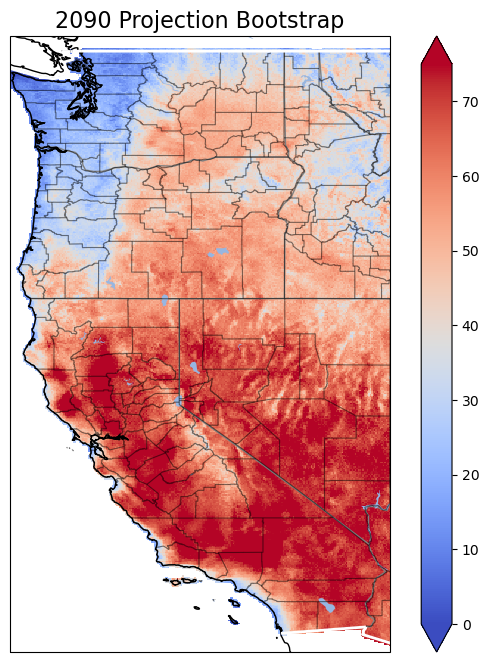

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Number of bootstrap iterations, 18 because 18 CMIP5 models 
num_iterations = 18

num_plots = 1
for i in range(num_plots):
    booted_trend_slope = blank.copy(deep=True)
    # iterates at each point
    for lon in residuals.lon.values:
        for lat in residuals.lat.values:
            # gives me residuals at each point and the predicated value at each point from the gridmet data
            actual_residuals = (residuals.sel(lon=lon, lat=lat, method = 'nearest')).values
            actual_trendline_values = (trendline_values.sel(lon=lon, lat=lat, method = 'nearest')).values
            # Perform bootstrap iterations where projection_2060_array is array of 2060 projections for each bootstrap
            projection_2060_array_internal = []
            for _ in range(num_iterations):
                # Resample with replacement, randomizing the residuals
                resample_indices = np.random.choice(len(actual_residuals), len(actual_residuals), replace=True)
                boot_resid = actual_residuals[resample_indices] 
                resample_all_years = np.random.choice(len(actual_residuals), len(actual_residuals)+68, replace=True)
                boot_resid_allyears = actual_residuals[resample_all_years]
                
                # adding my randomized residuals back to my intial line of best fit for different values
                boot_sl = boot_resid + actual_trendline_values
            
                # Compute bootstrapped trend using np.polyfit (linear fit, degree=1)
                trend_coefficients = np.polyfit(range(len(boot_sl)), boot_sl, 1)
                # takes bootstrap trend projected values to 50 + initial length so to 2060 
                trend = np.polyval(trend_coefficients, range(len(boot_sl) + 68))
                all_values = trend + boot_resid_allyears
                # just takes the 2060 projected value
                projection_2060_internal = all_values[-1]
                # appends projected value at 2060 for each bootstrap to an array so projection_2060_array has 18 values, = amount of models
                projection_2060_array_internal.append(projection_2060_internal)
                
            # finishes with an array with 18 values, and take the average of the 18 2060 projections, replacing my 'blank' array at 
            # the appropriate lon / lat combination
            averaged_2060 = np.mean(projection_2060_array_internal)
            booted_trend_slope.loc[{'lon': lon, 'lat': lat}] = averaged_2060
            



    # then plot booted_trend_slope which is the bootstrapped projection at each location, where each location is an average of the 18 
    # bootstrapped projections
    reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
    counties = list(reader.geometries())
    #counties
    COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())
    
    shapefile_path = '/data/keeling/a/ctavila2/4_Model_Trendline/shape/ne_10m_ocean.shp'
    gdf_ocean = gpd.read_file(shapefile_path)
    
    scale = '110m'
    states110 = cfeature.NaturalEarthFeature(
                category='cultural',
                name='admin_1_states_provinces_lines',
                scale=scale,
                facecolor='none',
                edgecolor='r')
    
    cmap='pink'
    cmap='cividis'
    #cmap='viridis'
    cmap='coolwarm'
    # central_longitude=260.0
    ## (17,17)
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
    #print(booted_trend_slope)
    booted_trend_slope.plot(ax=ax,cmap=cmap,vmin=0,vmax=75)
    
    # Set the aspect ratio to 'box' for horizontal stretching
    # Replace min_x and max_x with appropriate values# Plot the second shapefile (gdf_wgs84)
    # Replace 'white' and 'black' with the desired colors and styling
    
    #gdf_wgs84.boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=1.0)
    
    # Set the extent and add other map features as needed
    #ax.set_extent([-125, -113, 30, 50], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
    ax.coastlines()
    ax.add_feature(cfeature.LAKES)
    ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
    ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')
    
#    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
#    gl.xlabel_style = {'size': 10, 'color': 'black'}
#    gl.ylabel_style = {'size': 10, 'color': 'black'}
    
    #gdf_ocean.plot(ax=ax, color='white', edgecolor='white', linewidth=1.0)
    
    plt.title('2090 Projection Bootstrap', fontsize=16)
    plt.savefig('/data/keeling/a/ctavila2/7_bootstrapping/final_plots/FIG 3 2060 Projections/2_a_0_GRIDMET_2090_Bootstrap_FWI_Projection_tmaxrhmin_native_18it_75_intvariabiliy_COMP')
    


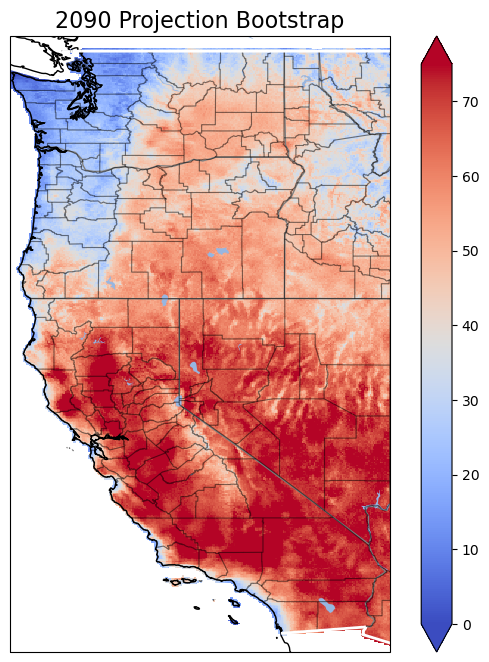

In [12]:
reader = shpreader.Reader('/data/keeling/a/ctavila2/2_maps/county_shapefile/countyl010g.shp')
counties = list(reader.geometries())
#counties
COUNTIES = cfeature.ShapelyFeature(counties, ccrs.PlateCarree())

shapefile_path = '/data/keeling/a/ctavila2/4_Model_Trendline/shape/ne_10m_ocean.shp'
gdf_ocean = gpd.read_file(shapefile_path)

scale = '110m'
states110 = cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale=scale,
            facecolor='none',
            edgecolor='r')

cmap='pink'
cmap='cividis'
#cmap='viridis'
cmap='coolwarm'
# central_longitude=260.0
## (17,17)
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': ccrs.PlateCarree()})
#print(booted_trend_slope)
booted_trend_slope.plot(ax=ax,cmap=cmap,vmin=0,vmax=75)

# Set the aspect ratio to 'box' for horizontal stretching
# Replace min_x and max_x with appropriate values# Plot the second shapefile (gdf_wgs84)
# Replace 'white' and 'black' with the desired colors and styling

#gdf_wgs84.boundary.plot(ax=ax, color='none', edgecolor='red', linewidth=1.0)

# Set the extent and add other map features as needed
#ax.set_extent([-125, -113, 30, 50], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '110m', edgecolor='gray', facecolor='none'))
ax.coastlines()
ax.add_feature(cfeature.LAKES)
ax.add_feature(COUNTIES, linewidth=0.8, alpha=0.5, facecolor='none', edgecolor='black')
ax.add_feature(cfeature.BORDERS, linewidth=2, edgecolor='white')

#    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
#    gl.xlabel_style = {'size': 10, 'color': 'black'}
#    gl.ylabel_style = {'size': 10, 'color': 'black'}

#gdf_ocean.plot(ax=ax, color='white', edgecolor='white', linewidth=1.0)

plt.title('2090 Projection Bootstrap', fontsize=16)
plt.savefig('/data/keeling/a/ctavila2/7_bootstrapping/final_plots/3_0_GRIDMET_2090_Bootstrap_FWI_Projection_tmaxrhmin_native_18it__75')